# Basic Needs Basic Rights Kenya - Tech4MentalHealth

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tech4mentalhealthsamplesubmission/SampleSubmission.csv
/kaggle/input/v4roberta/v4-roberta-4.h5
/kaggle/input/v4roberta/v4-roberta-1.h5
/kaggle/input/v4roberta/v4-roberta-0.h5
/kaggle/input/v4roberta/v4-roberta-2.h5
/kaggle/input/v4roberta/v4-roberta-3.h5
/kaggle/input/testzindi/Test.csv
/kaggle/input/trainzindi/Train.csv
/kaggle/input/tf-roberta/vocab-roberta-base.json
/kaggle/input/tf-roberta/pretrained-roberta-base.h5
/kaggle/input/tf-roberta/merges-roberta-base.txt
/kaggle/input/tf-roberta/config-roberta-base.json


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/ import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch
import string

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=10,6
plt.rcParams['axes.grid']=True
plt.gray()

use_cuda = True
pd.set_option('display.max_columns', None)

<Figure size 720x432 with 0 Axes>

In [3]:
Train = pd.read_csv("/kaggle/input/trainzindi/Train.csv")
Test = pd.read_csv("/kaggle/input/testzindi/Test.csv")
SampleSubmission = pd.read_csv("/kaggle/input/tech4mentalhealthsamplesubmission/SampleSubmission.csv")

In [4]:
Test

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?
...,...,...
304,Z9A6ACLK,Yes
305,ZDUOIGKN,My girlfriend dumped me
306,ZHQ60CCH,How can I go back to being my old self?
307,ZVIJMA4O,Is it true bhang is medicinal?


In [5]:
SampleSubmission["Alcohol"].unique()

array([0])

In [6]:
# Checking the shape of train and test data
print(Train.shape)
print(Test.shape)

(616, 3)
(309, 2)


In [7]:
# Checking Missing value in the training set
print(Train.isnull().sum())
# Checking Missing Value in the testing set
print(Test.isnull().sum())

ID       0
text     0
label    0
dtype: int64
ID      0
text    0
dtype: int64


In [8]:
# Création d'une fonction permettant de calculer le total de valeurs manquantes, le pourcentage et le type de 
 ## chaque colonne 
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [9]:
missing_data(Train)

,ID,text,label
Total,0,0,0
Percent,0,0,0
Types,object,object,object


In [10]:
missing_data(Test)

,ID,text
Total,0,0
Percent,0,0
Types,object,object


In [11]:
percent_label = Train.groupby('label').count()
percent_label['percent'] = 100*(percent_label['text']/Train['label'].count())
percent_label.reset_index(level=0, inplace=True)
percent_label

,label,ID,text,percent
0,Alcohol,140,140,22.727273
1,Depression,352,352,57.142857
2,Drugs,58,58,9.415584
3,Suicide,66,66,10.714286


In [12]:
# Droping the row with missing values
Train.dropna(axis = 0, how ='any',inplace=True)

In [13]:
# Alcohol tweet
print("Alcohol Tweet example :",Train[Train['label']=='Alcohol']['text'].values[0])
#Depression tweet
print("Depression Tweet example :",Train[Train['label']=='Depression']['text'].values[0])
#Drugs tweetTrain
print("Drugs tweet example  :",Train[Train['label']=='Drugs']['text'].values[0])

#Suicide tweet
print("Suicide tweet example  :",Train[Train['label']=='Suicide']['text'].values[0])

Alcohol Tweet example : How to manage taking alcohol?
Depression Tweet example : I feel that it was better I dieAm happy
Drugs tweet example  : Why do I get hallucinations?
Suicide tweet example  : Why is life important?


In [14]:
# Distribution of the label Column
Train['label'].value_counts()

Depression    352
Alcohol       140
Suicide        66
Drugs          58
Name: label, dtype: int64

In [15]:
Train['label'].value_counts(normalize=True)

Depression    0.571429
Alcohol       0.227273
Suicide       0.107143
Drugs         0.094156
Name: label, dtype: float64

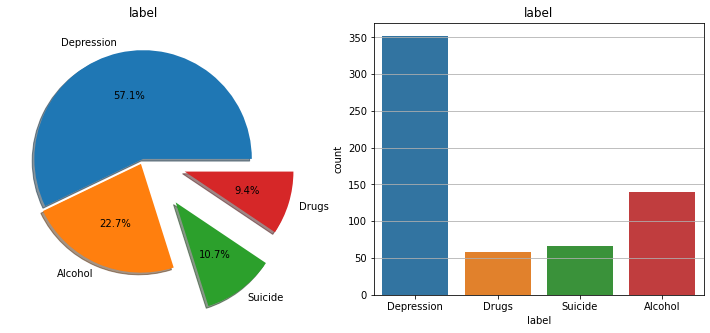

In [16]:
f,ax=plt.subplots(1,2,figsize=(13,5))
Train['label'].value_counts().plot.pie(explode=[0,0.05,0.5, 0.4],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('label')
ax[0].set_ylabel('')
sns.countplot('label',data=Train,ax=ax[1])
ax[1].set_title('label')
plt.show()



In [17]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk import wordnet, pos_tag
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet as wn
import re
import string

#Cleaning data

def clean_str(chaine):
    chaine = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", chaine)     
    chaine = re.sub(r"\'s", " \'s", chaine) 
    chaine = re.sub(r"\'ve", " \'ve", chaine) 
    chaine = re.sub(r"n\'t", " n\'t", chaine) 
    chaine = re.sub(r"\'re", " \'re", chaine) 
    chaine = re.sub(r"\'d", " \'d", chaine) 
    chaine = re.sub(r"\'ll", " \'ll", chaine) 
    chaine = re.sub(r",", " , ", chaine) 
    chaine = re.sub(r"!", " ! ", chaine) 
    chaine = re.sub(r"\(", " \( ", chaine) 
    chaine = re.sub(r"\)", " \) ", chaine) 
    chaine = re.sub(r"\?", " \? ", chaine) 
    chaine = re.sub(r"\s{2,}", " ", chaine)
    chaine = chaine.lower() #convert all text in lower case
    chaine = chaine.replace(' +', ' ') # Remove double space
    chaine = chaine.strip() # Remove trailing space at the beginning or end
    chaine = chaine.replace('[^a-zA-Z]', ' ' )# Everything not a alphabet character replaced with a space
    #words =  [word for word in chaine.split() if word not in [i for i in string.punctuation]] #Remove punctuations
    words =  [word for word in chaine.split() if word.isalpha()] #droping numbers and punctuations
    return ' '.join(words)

#Tokenization and punctuation removing and stopwords
def tokeniZ_stopWords(chaine):
    chaine = word_tokenize(chaine)
    list_stopWords = set(stopwords.words('english'))
    words = [word for word in chaine if word not in list_stopWords]
    return words

#Stemming 
ps = PorterStemmer()
sb = SnowballStemmer('english')

#Lemmatization
def lemat_words(tokens_list):
    from collections import defaultdict
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    lemma_function = WordNetLemmatizer()
    return [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens_list)]
    #for token, tag in pos_tag(tokens_list):
     #   lemma = lemma_function.lemmatize(token, tag_map[tag[0]])

# Define Ngrams function
def get_ngrams(text, n ):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

### Text analysis in training data 

In [18]:
#Cleaning the train data 
Train['text_clean'] = Train['text'].apply(clean_str)

#Tokenizing and stopwords removing
Train['tokeniZ_stopWords_text'] = Train['text_clean'].apply(tokeniZ_stopWords)
#Words Stemming
Train['stemming_text'] = [[ps.stem(word) for word in words] for words in Train['tokeniZ_stopWords_text'] ]
Train['stemming_text_for_tfidf'] = [' '.join(words) for words in Train['stemming_text']] 

#Words lemmatization
Train['lemmatize_text'] = Train['tokeniZ_stopWords_text'].apply(lemat_words)
Train['lemmatize_text_for_tfidf'] = [' '.join(x) for x in Train['lemmatize_text'] ]

#Calcul longueur des commentaires
Train['text_lenght'] = Train['text'].apply(len)

#Calcul du nombre de ponctuation par question
from string import punctuation
Train['number_punctuation_text'] = Train['text'].apply(
    lambda doc: len([word for word in str(doc) if word in punctuation])) 

#Number of unique words in the text
Train['number_of_Unique_words_text'] = Train['text_clean'].apply([lambda x : len(set(str(x).split()))])

#Number of stopwords in the text
list_stopWords = set(stopwords.words('english'))
Train['number_of_StopWords_text'] = Train['text_clean'].apply(
    lambda x : len([w for w in x.lower().split() if w in list_stopWords ]))


#Number of upper case words
Train['number_of_uppercase_text'] = Train['text'].apply(
    lambda x : len([w for w in x.split() if w.isupper()]))


#Average length of words in the text (whithout stop words)
Train['average_of_wordsLength_text'] = Train['text_clean'].apply(
    lambda x : np.mean([len(w) for w in x.split()]))

#Number of words in the text
Train['number_of_words_text'] = Train['text_clean'].apply([lambda x : len(str(x).split())])

In [19]:
Train['label'].unique()

array(['Depression', 'Drugs', 'Suicide', 'Alcohol'], dtype=object)

In [20]:
# Let's create three separate dataframes for positive, neutral and negative sentiments. 
#This will help in analyzing the text statistics separately for separate polarities.

Depression = Train[Train['label']=='Depression']
Drugs = Train[Train['label']=='Drugs']
Suicide = Train[Train['label']=='Suicide']
Alcohol = Train[Train['label']=='Alcohol']

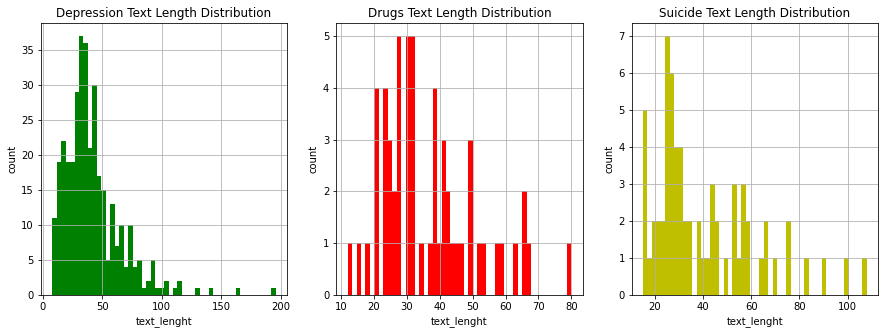

In [21]:
# Sentence length analysis

fig, ax = plt.subplots(1, 4, figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(Depression['text_lenght'],bins=50,color='g')
plt.title('Depression Text Length Distribution')
plt.xlabel('text_lenght')
plt.ylabel('count')


plt.subplot(1, 3, 2)
plt.hist(Drugs['text_lenght'],bins=50,color='r')
plt.title('Drugs Text Length Distribution')
plt.xlabel('text_lenght')
plt.ylabel('count')


plt.subplot(1, 3, 3)
plt.hist(Suicide['text_lenght'],bins=50,color='y')
plt.title('Suicide Text Length Distribution')
plt.xlabel('text_lenght')
plt.ylabel('count')


plt.show()



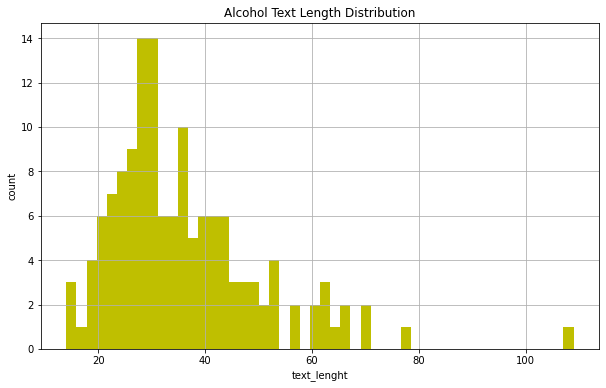

In [22]:
#plt.subplot(1, 3, 3)
plt.hist(Alcohol['text_lenght'],bins=50,color='y')
plt.title('Alcohol Text Length Distribution')
plt.xlabel('text_lenght')
plt.ylabel('count')
plt.show()

In [23]:
#source of code : https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

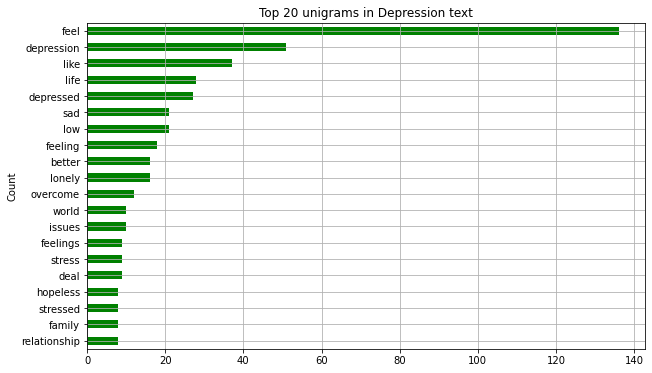

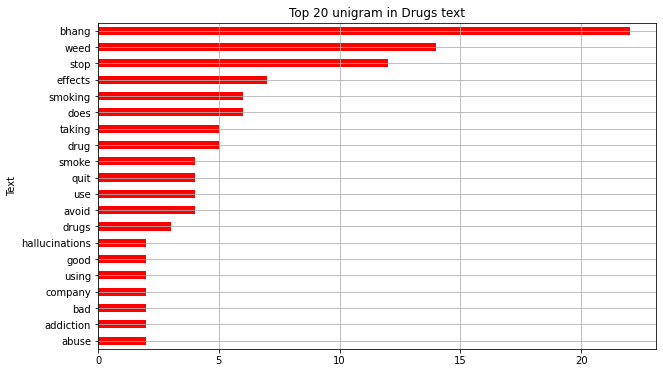

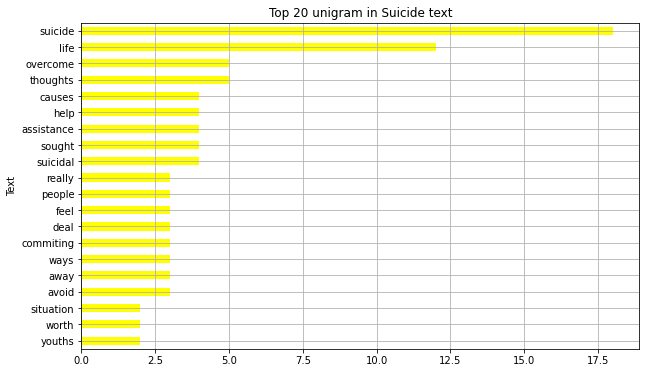

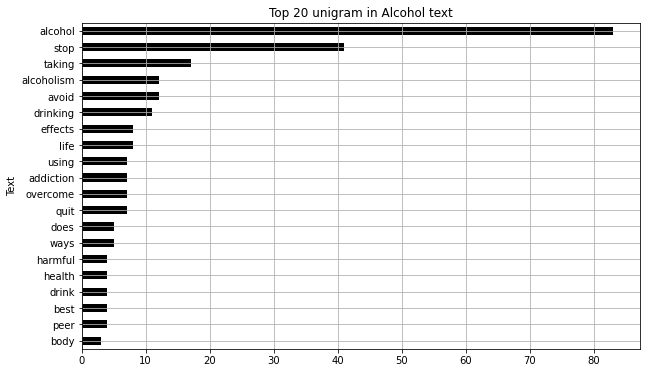

In [24]:
#Distribution of top unigrams
Depression_unigrams = get_top_n_words(Depression['text_clean'],20)
Drugs_unigrams = get_top_n_words(Drugs['text_clean'],20)
Suicide_unigrams = get_top_n_words(Suicide['text_clean'],20)
Alcohol_unigrams = get_top_n_words(Alcohol['text_clean'],20)

df1 = pd.DataFrame(Depression_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='g')
plt.ylabel('Count')
plt.title('Top 20 unigrams in Depression text')
plt.show()

df2 = pd.DataFrame(Drugs_unigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='red')
plt.title('Top 20 unigram in Drugs text')
plt.show()

df3 = pd.DataFrame(Suicide_unigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='yellow')
plt.title('Top 20 unigram in Suicide text')
plt.show()

df4 = pd.DataFrame(Alcohol_unigrams, columns = ['Text' , 'count'])
df4.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='black')
plt.title('Top 20 unigram in Alcohol text')
plt.show()

In [25]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

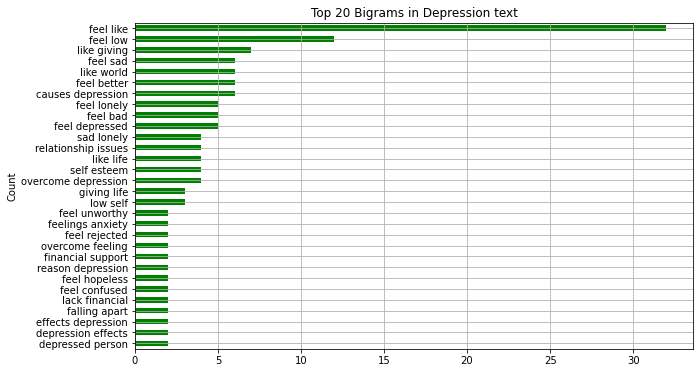

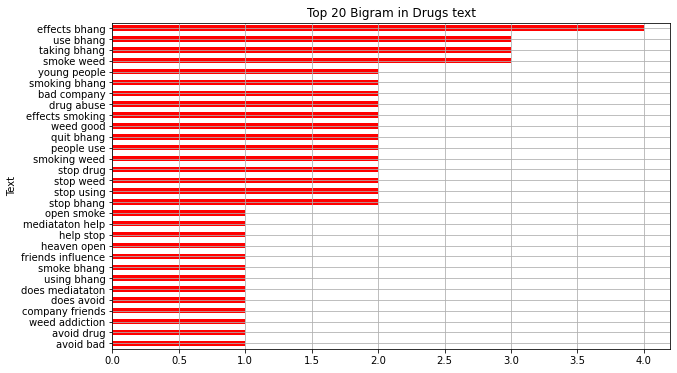

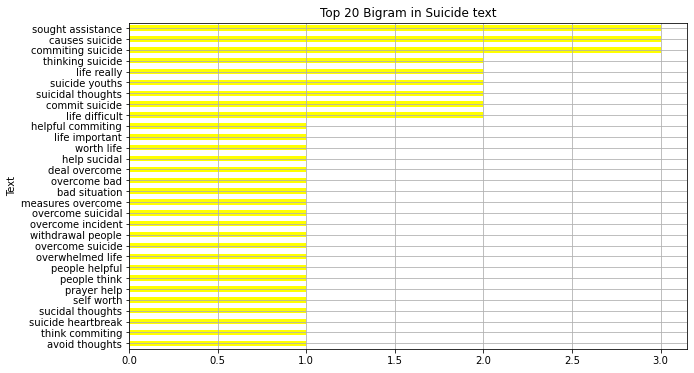

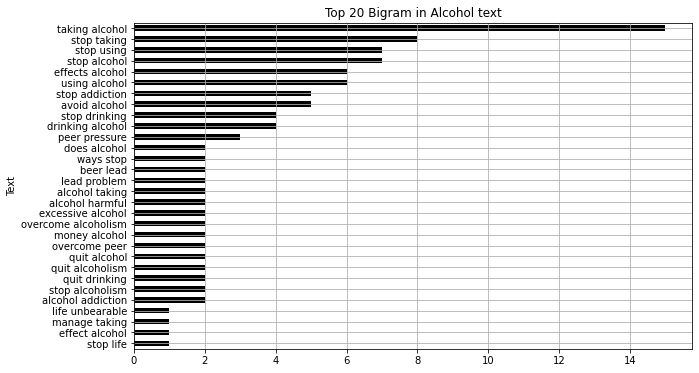

In [26]:
#Distribution of top Bigrams
Depression_bigrams = get_top_n_gram(Depression['text_clean'],(2,2),30)
Drugs_bigrams = get_top_n_gram(Drugs['text_clean'],(2,2),30)
Suicide_bigrams = get_top_n_gram(Suicide['text_clean'],(2,2),30)
Alcohol_bigrams = get_top_n_gram(Alcohol['text_clean'],(2,2),30)

df1 = pd.DataFrame(Depression_bigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='g')
plt.ylabel('Count')
plt.title('Top 20 Bigrams in Depression text')
plt.show()

df2 = pd.DataFrame(Drugs_bigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='red')
plt.title('Top 20 Bigram in Drugs text')
plt.show()

df3 = pd.DataFrame(Suicide_bigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='yellow')
plt.title('Top 20 Bigram in Suicide text')
plt.show()

#Depression_bigrams = get_top_n_gram(Depression['text_clean'],(2,2),30)
df4 = pd.DataFrame(Alcohol_bigrams, columns = ['Text' , 'count'])
df4.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='black')
plt.title('Top 20 Bigram in Alcohol text')
plt.show()

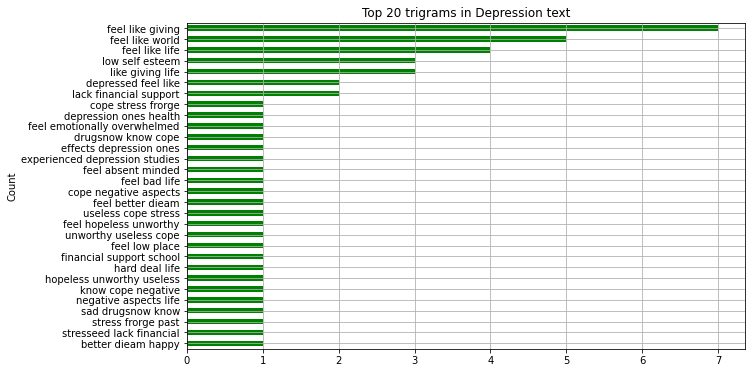

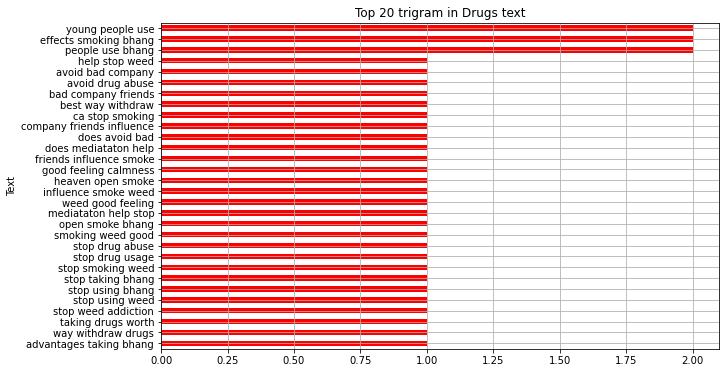

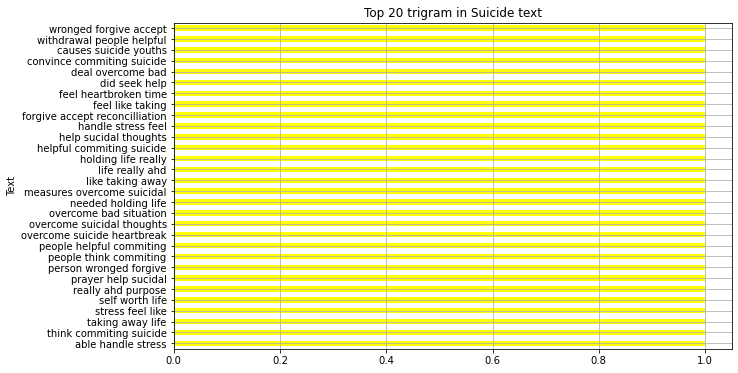

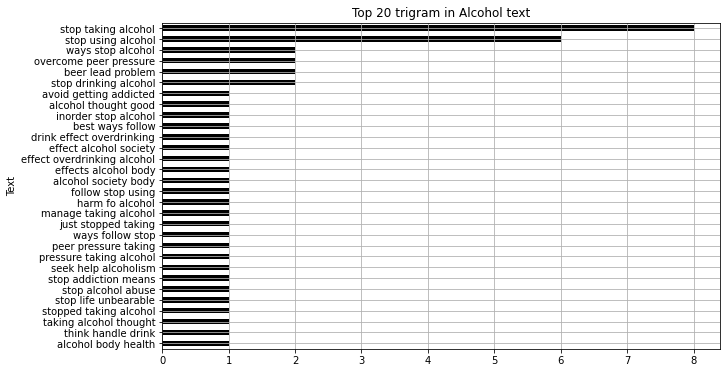

In [27]:
# Finding top trigram
Depression_trigrams = get_top_n_gram(Depression['text_clean'],(3,3),30)
Drugs_trigrams = get_top_n_gram(Drugs['text_clean'],(3,3),30)
Suicide_trigrams = get_top_n_gram(Suicide['text_clean'],(3,3),30)
Alcohol_trigrams = get_top_n_gram(Alcohol['text_clean'],(3,3),30)

df1 = pd.DataFrame(Depression_trigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='g')
plt.ylabel('Count')
plt.title('Top 20 trigrams in Depression text')
plt.show()

df2 = pd.DataFrame(Drugs_trigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='red')
plt.title('Top 20 trigram in Drugs text')
plt.show()

df3 = pd.DataFrame(Suicide_trigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='yellow')
plt.title('Top 20 trigram in Suicide text')
plt.show()

#Depression_trigrams = get_top_n_gram(Depression['text_clean'],(3,3),30)
df4 = pd.DataFrame(Alcohol_trigrams, columns = ['Text' , 'count'])
df4.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='black')
plt.title('Top 20 trigram in Alcohol text')
plt.show()

In [28]:
#df2.head()

In [29]:
#  Exploring the text column


Depression_text = Train[Train['label'] == 'Depression']['text']
Drugs_text = Train[Train['label'] == 'Drugs']['text']
Suicide_text = Train[Train['label'] == 'Suicide']['text']
Alcohol_text = Train[Train['label'] == 'Alcohol']['text']

#Depression Drugs Suicide Alcohol

In [30]:
# Depression text
print("Positive Text example :",Depression_text.values[0])
#Drugs_text
print("Drugs Tweet example :",Drugs_text.values[0])
#Suicide_text
print("Suicide tweet example  :",Suicide_text.values[0])
#Alcohol_text
print("Neutral tweet example  :",Alcohol_text.values[0])

Positive Text example : I feel that it was better I dieAm happy
Drugs Tweet example : Why do I get hallucinations?
Suicide tweet example  : Why is life important?
Neutral tweet example  : How to manage taking alcohol?


In [31]:
# Preprocess Selected_text

Depression_text_clean = Depression_text.apply(clean_str)
Drugs_text_clean = Drugs_text.apply(clean_str)
Suicide_text_clean = Suicide_text.apply(clean_str)
Alcohol_text_clean = Alcohol_text.apply(clean_str)

In [32]:
#source of code : https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [33]:
top_words_in_Depression_text = get_top_n_words(Depression_text_clean)
top_words_in_Drugs_text = get_top_n_words(Drugs_text_clean)
top_words_in_Suicide_text = get_top_n_words(Suicide_text_clean)
top_words_in_Alcohol_text = get_top_n_words(Alcohol_text_clean)

p1 = [x[0] for x in top_words_in_Depression_text[:20]]
p2 = [x[1] for x in top_words_in_Depression_text[:20]]


n1 = [x[0] for x in top_words_in_Drugs_text[:20]]
n2 = [x[1] for x in top_words_in_Drugs_text[:20]]


nu1 = [x[0] for x in top_words_in_Suicide_text[:20]]
nu2 = [x[1] for x in top_words_in_Suicide_text[:20]]

mu1 = [x[0] for x in top_words_in_Alcohol_text[:20]]
mu2 = [x[1] for x in top_words_in_Alcohol_text[:20]]

In [34]:
top_words_in_Depression_text

[('feel', 136),
 ('depression', 51),
 ('like', 37),
 ('life', 28),
 ('depressed', 27),
 ('sad', 21),
 ('low', 21),
 ('feeling', 18),
 ('better', 16),
 ('lonely', 16),
 ('overcome', 12),
 ('world', 10),
 ('issues', 10),
 ('deal', 9),
 ('stress', 9),
 ('feelings', 9),
 ('hopeless', 8),
 ('stressed', 8),
 ('relationship', 8),
 ('family', 8),
 ('bad', 7),
 ('things', 7),
 ('situation', 7),
 ('giving', 7),
 ('want', 7),
 ('causes', 7),
 ('financial', 6),
 ('money', 6),
 ('avoid', 6),
 ('lost', 6),
 ('people', 6),
 ('lack', 5),
 ('school', 5),
 ('effects', 5),
 ('cope', 5),
 ('unwanted', 5),
 ('lot', 5),
 ('help', 5),
 ('okay', 5),
 ('thoughts', 5),
 ('discouraged', 5),
 ('overwhelmed', 4),
 ('experienced', 4),
 ('unworthy', 4),
 ('control', 4),
 ('financially', 4),
 ('wasted', 4),
 ('way', 4),
 ('self', 4),
 ('esteem', 4),
 ('felt', 4),
 ('exams', 4),
 ('just', 4),
 ('death', 4),
 ('parents', 4),
 ('dealing', 4),
 ('close', 4),
 ('issue', 4),
 ('good', 4),
 ('happy', 3),
 ('support', 3),
 (

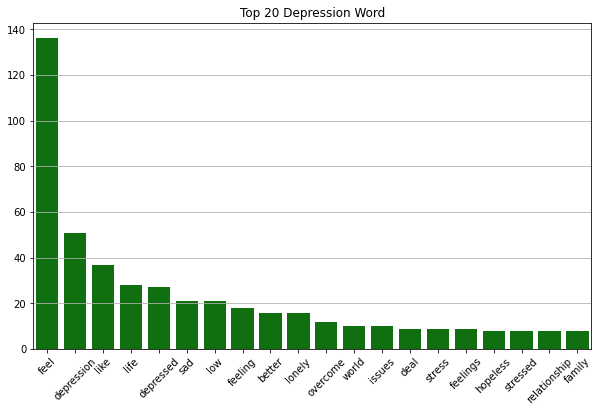

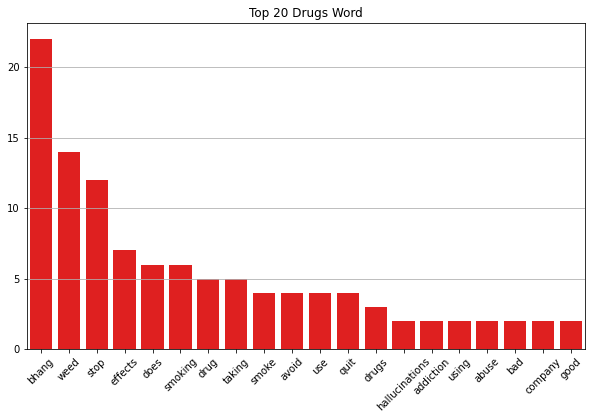

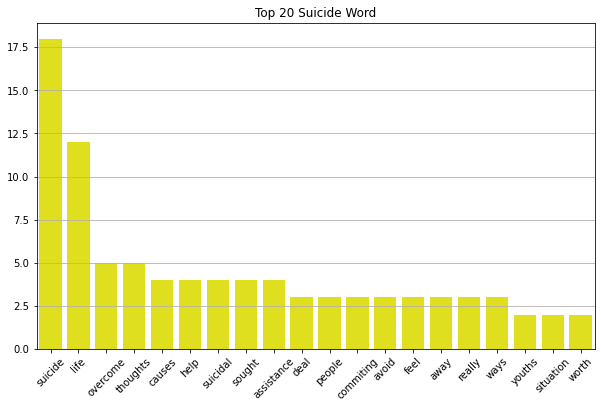

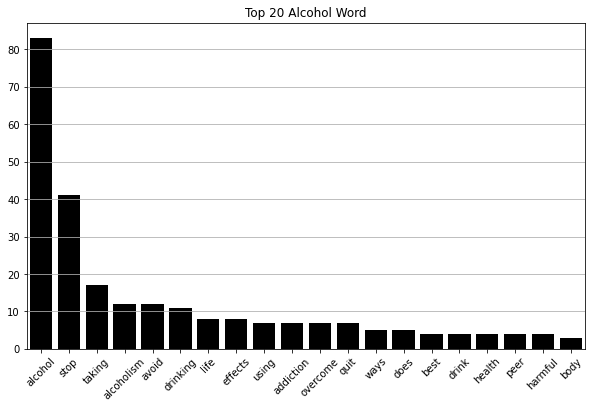

In [35]:
# Top positive word
sns.barplot(x=p1,y=p2,color = 'green')
plt.xticks(rotation=45)
plt.title('Top 20 Depression Word')
plt.show()

sns.barplot(x=n1,y=n2,color='red')
plt.xticks(rotation=45)
plt.title('Top 20 Drugs Word')
plt.show()

sns.barplot(x=nu1,y=nu2,color='yellow')
plt.xticks(rotation=45)
plt.title('Top 20 Suicide Word')
plt.show()

sns.barplot(x=mu1,y=mu2,color='black')
plt.xticks(rotation=45)
plt.title('Top 20 Alcohol Word')
plt.show()

Text(0.5, 1.0, 'Alcohol text')

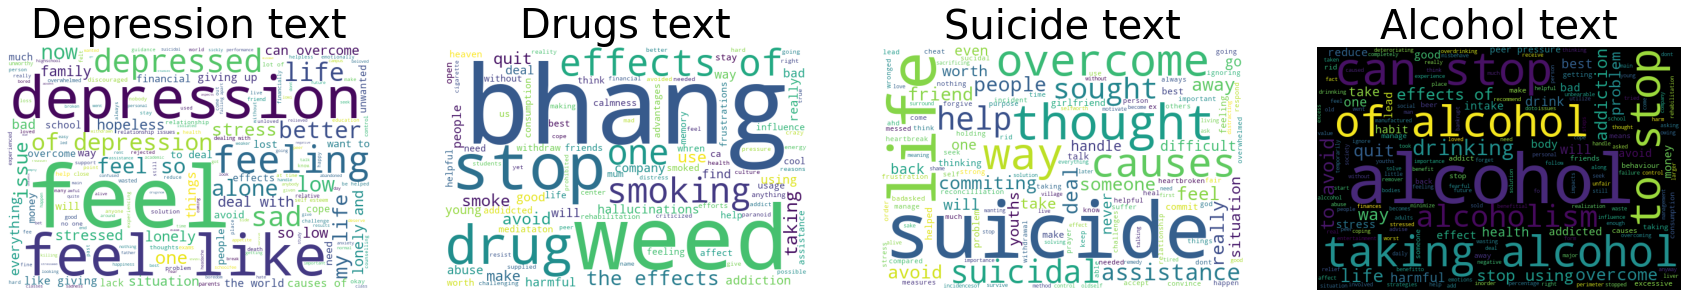

In [36]:

#Wordclouds
# Wordclouds to see which words contribute to which type of polarity.

from wordcloud import WordCloud
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(Depression_text_clean))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Depression text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(Drugs_text_clean))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Drugs text',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(Suicide_text_clean))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Suicide text',fontsize=40)

wordcloud4 = WordCloud( background_color='black',
                        width=600,
                        height=400).generate(" ".join(Alcohol_text_clean))
ax4.imshow(wordcloud4)
ax4.axis('off')
ax4.set_title('Alcohol text',fontsize=40)

In [37]:
##Depression Drugs Suicide Alcohol
# https://www.kaggle.com/ekhtiar/unintended-eda-with-tutorial-notes
def generate_word_cloud(df_data, text_col):
    # convert stop words to sets as required by the wordcloud library
    stop_words = set(stopwords.words("english"))
    
    data_Depression = " ".join(df_data.loc[df_data["label"]=="Depression", text_col].map(lambda x: str(x).lower()))
    data_Drugs = " ".join(df_data.loc[df_data["label"]=="Drugs", text_col].map(lambda x: str(x).lower()))
    data_Suicide = " ".join(df_data.loc[df_data["label"]=="Suicide", text_col].map(lambda x: str(x).lower()))
    data_Alcohol = " ".join(df_data.loc[df_data["label"]=="Alcohol", text_col].map(lambda x: str(x).lower()))

    wc_Depression = WordCloud(max_font_size=100, max_words=100, background_color="white", stopwords=stop_words).generate(data_Depression)
    wc_Drugs = WordCloud(max_font_size=100, max_words=100, background_color="white", stopwords=stop_words).generate(data_Drugs)
    wc_Suicide = WordCloud(max_font_size=100, max_words=100, background_color="white", stopwords=stop_words).generate(data_Suicide)
    wc_Alcohol = WordCloud(max_font_size=100, max_words=100, background_color="white", stopwords=stop_words).generate(data_Alcohol)

    # draw the two wordclouds side by side using subplot
    fig, ax = plt.subplots(1, 4, figsize=(20, 20))
    ax[0].set_title("Depression Wordcloud" , fontsize=10)
    ax[0].imshow(wc_Depression, interpolation="bilinear")
    ax[0].axis("off")
    
    ax[1].set_title("Drugs Wordcloud", fontsize=10)
    ax[1].imshow(wc_Drugs, interpolation="bilinear")
    ax[1].axis("off")
    
    ax[2].set_title("Suicide Wordcloud", fontsize=10)
    ax[2].imshow(wc_Suicide, interpolation="bilinear")
    ax[2].axis("off")
    
    
    ax[3].set_title("Alcohol Wordcloud", fontsize=5)
    ax[3].imshow(wc_Alcohol, interpolation="bilinear")
    ax[3].axis("off")
    plt.show()
    
    return [wc_Depression, wc_Drugs, wc_Suicide, wc_Alcohol]

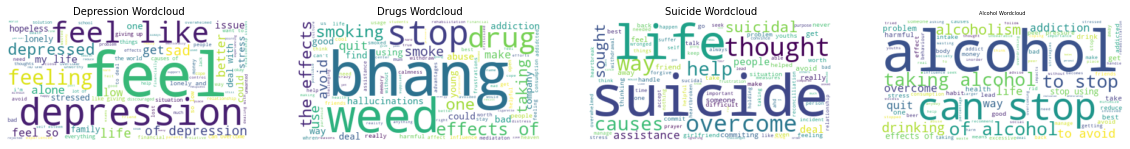

In [38]:
Train_text_wc = generate_word_cloud(Train, "text")

In [39]:
missing_data(Train)

,ID,text,label,text_clean,tokeniZ_stopWords_text,stemming_text,stemming_text_for_tfidf,lemmatize_text,lemmatize_text_for_tfidf,text_lenght,number_punctuation_text,number_of_Unique_words_text,number_of_StopWords_text,number_of_uppercase_text,average_of_wordsLength_text,number_of_words_text
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,int64,float64,int64


## Target variable creating

In [40]:
##Depression Drugs Suicide Alcohol
Train['Target'] = Train['label'].apply(lambda x: 2 if x == 'Depression' else 1 if x == 'Drugs' else 3 if x == 'Suicide' else 0)
Train.head()

,ID,text,label,text_clean,tokeniZ_stopWords_text,stemming_text,stemming_text_for_tfidf,lemmatize_text,lemmatize_text_for_tfidf,text_lenght,number_punctuation_text,number_of_Unique_words_text,number_of_StopWords_text,number_of_uppercase_text,average_of_wordsLength_text,number_of_words_text,Target
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,i feel that it was better i dieam happy,"[feel, better, dieam, happy]","[feel, better, dieam, happi]",feel better dieam happi,"[feel, well, dieam, happy]",feel well dieam happy,39,0,8,5,2,3.444444,9,2
1,9JDAGUV3,Why do I get hallucinations?,Drugs,why do i get hallucinations,"[get, hallucinations]","[get, hallucin]",get hallucin,"[get, hallucination]",get hallucination,28,1,5,3,1,4.600000,5,1
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,i am stresseed due to lack of financial suppor...,"[stresseed, due, lack, financial, support, sch...","[stresse, due, lack, financi, support, school]",stresse due lack financi support school,"[stresseed, due, lack, financial, support, sch...",stresseed due lack financial support school,57,0,11,5,1,4.272727,11,2
3,6UY7DX6Q,Why is life important?,Suicide,why is life important,"[life, important]","[life, import]",life import,"[life, important]",life important,22,1,4,2,0,4.500000,4,3
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,how could i be helped to go through the depres...,"[could, helped, go, depression]","[could, help, go, depress]",could help go depress,"[could, help, go, depression]",could help go depression,51,1,10,6,1,4.100000,10,2


In [41]:
T = Train[["label", "Target"]]
T

,label,Target
0,Depression,2
1,Drugs,1
2,Depression,2
3,Suicide,3
4,Depression,2
...,...,...
611,Alcohol,0
612,Suicide,3
613,Alcohol,0
614,Depression,2


In [42]:
percent_target = Train.groupby('Target').count()
percent_target['percent'] = 100*(percent_target['text']/Train['Target'].count())
percent_target.reset_index(level=0, inplace=True)
percent_target

,Target,ID,text,label,text_clean,tokeniZ_stopWords_text,stemming_text,stemming_text_for_tfidf,lemmatize_text,lemmatize_text_for_tfidf,text_lenght,number_punctuation_text,number_of_Unique_words_text,number_of_StopWords_text,number_of_uppercase_text,average_of_wordsLength_text,number_of_words_text,percent
0,0,140,140,140,140,140,140,140,140,140,140,140,140,140,140,140,140,22.727273
1,1,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,9.415584
2,2,352,352,352,352,352,352,352,352,352,352,352,352,352,352,352,352,57.142857
3,3,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,10.714286


## Features engineering for training data

In [43]:
Train.head()

,ID,text,label,text_clean,tokeniZ_stopWords_text,stemming_text,stemming_text_for_tfidf,lemmatize_text,lemmatize_text_for_tfidf,text_lenght,number_punctuation_text,number_of_Unique_words_text,number_of_StopWords_text,number_of_uppercase_text,average_of_wordsLength_text,number_of_words_text,Target
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,i feel that it was better i dieam happy,"[feel, better, dieam, happy]","[feel, better, dieam, happi]",feel better dieam happi,"[feel, well, dieam, happy]",feel well dieam happy,39,0,8,5,2,3.444444,9,2
1,9JDAGUV3,Why do I get hallucinations?,Drugs,why do i get hallucinations,"[get, hallucinations]","[get, hallucin]",get hallucin,"[get, hallucination]",get hallucination,28,1,5,3,1,4.600000,5,1
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,i am stresseed due to lack of financial suppor...,"[stresseed, due, lack, financial, support, sch...","[stresse, due, lack, financi, support, school]",stresse due lack financi support school,"[stresseed, due, lack, financial, support, sch...",stresseed due lack financial support school,57,0,11,5,1,4.272727,11,2
3,6UY7DX6Q,Why is life important?,Suicide,why is life important,"[life, important]","[life, import]",life import,"[life, important]",life important,22,1,4,2,0,4.500000,4,3
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,how could i be helped to go through the depres...,"[could, helped, go, depression]","[could, help, go, depress]",could help go depress,"[could, help, go, depression]",could help go depression,51,1,10,6,1,4.100000,10,2


In [44]:
Train.tail()

,ID,text,label,text_clean,tokeniZ_stopWords_text,stemming_text,stemming_text_for_tfidf,lemmatize_text,lemmatize_text_for_tfidf,text_lenght,number_punctuation_text,number_of_Unique_words_text,number_of_StopWords_text,number_of_uppercase_text,average_of_wordsLength_text,number_of_words_text,Target
611,BOHSNXCN,What should I do to stop alcoholism?,Alcohol,what should i do to stop alcoholism,"[stop, alcoholism]","[stop, alcohol]",stop alcohol,"[stop, alcoholism]",stop alcoholism,36,1,7,5,1,4.142857,7,0
612,GVDXRQPY,How to become my oldself again,Suicide,how to become my oldself again,"[become, oldself]","[becom, oldself]",becom oldself,"[become, oldself]",become oldself,30,0,6,4,0,4.166667,6,3
613,IO4JHIQS,How can someone stop it?,Alcohol,how can someone stop it,"[someone, stop]","[someon, stop]",someon stop,"[someone, stop]",someone stop,24,1,5,3,0,3.800000,5,0
614,1DS3P1XO,I feel unworthy,Depression,i feel unworthy,"[feel, unworthy]","[feel, unworthi]",feel unworthi,"[feel, unworthy]",feel unworthy,16,0,3,1,1,4.333333,3,2
615,ORF71PVQ,I feel so discouraged with life,Depression,i feel so discouraged with life,"[feel, discouraged, life]","[feel, discourag, life]",feel discourag life,"[feel, discourage, life]",feel discourage life,31,0,6,3,1,4.333333,6,2


In [45]:
Train.dtypes

ID                              object
text                            object
label                           object
text_clean                      object
tokeniZ_stopWords_text          object
stemming_text                   object
stemming_text_for_tfidf         object
lemmatize_text                  object
lemmatize_text_for_tfidf        object
text_lenght                      int64
number_punctuation_text          int64
number_of_Unique_words_text      int64
number_of_StopWords_text         int64
number_of_uppercase_text         int64
average_of_wordsLength_text    float64
number_of_words_text             int64
Target                           int64
dtype: object

In [46]:
Train[['text_lenght', 'number_punctuation_text', 'number_of_words_text',
       'number_of_Unique_words_text', 'number_of_StopWords_text', 'number_of_uppercase_text',
       'average_of_wordsLength_text']].sample(5)

,text_lenght,number_punctuation_text,number_of_words_text,number_of_Unique_words_text,number_of_StopWords_text,number_of_uppercase_text,average_of_wordsLength_text
2,57,0,11,11,5,1,4.272727
395,57,1,11,11,7,0,4.181818
62,19,1,5,5,3,1,2.800000
466,53,0,7,7,3,0,6.714286
470,25,0,5,5,2,0,4.200000


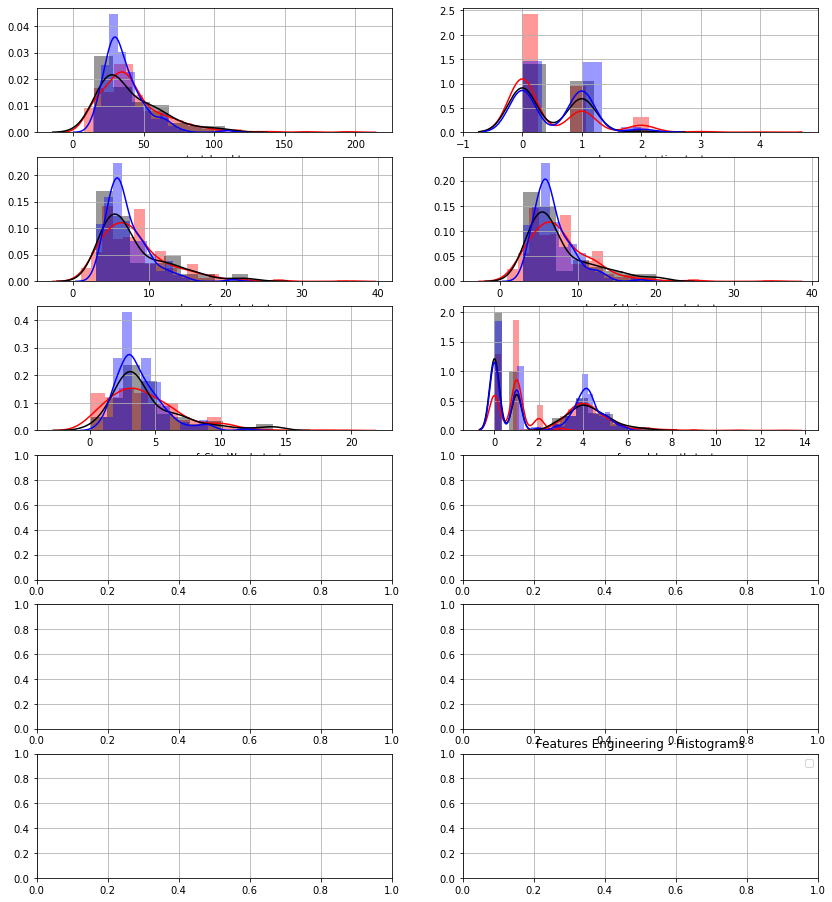

In [47]:




list_var=['text_lenght', 'number_punctuation_text', 'number_of_words_text',
       'number_of_Unique_words_text', 'number_of_StopWords_text', 'number_of_uppercase_text','average_of_wordsLength_text']
def var_hist_global(df,X='Target',Y=list_var, Title='Features Engineering - Histograms', KDE=False):
    fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6),(ax7,ax7),(ax7,ax8),(ax9,ax10)) = plt.subplots(6, 2 ,figsize=(14,16))#, sharey=True )
    aX = [ax1, ax2,ax3,ax4,ax5,ax6,ax6,ax7,ax8,ax9,ax10]
    for i in range(len(list_var)):   
        sns.distplot( df[list_var[i]][df[X]== 2 ].dropna(), label="Depression" , ax= aX[i], kde= KDE , color = 'red')           
        #sns.distplot( df[list_var[i]][df[X]== 1 ].dropna(), label="Drugs", ax= aX[i], kde= KDE , color = "olive")
        sns.distplot( df[list_var[i]][df[X]== 3 ].dropna(), label="Suicide", ax= aX[i], kde= KDE , color = "black")
        sns.distplot( df[list_var[i]][df[X]== 0 ].dropna(), label="Alcohol", ax= aX[i], kde= KDE , color = "blue")
    plt.legend()
    plt.title(Title)
    plt.show()
    ##plt.savefig("Features_Engineering_Histograms")
    
var_hist_global(df=Train,X='Target',Y=list_var, KDE=True)

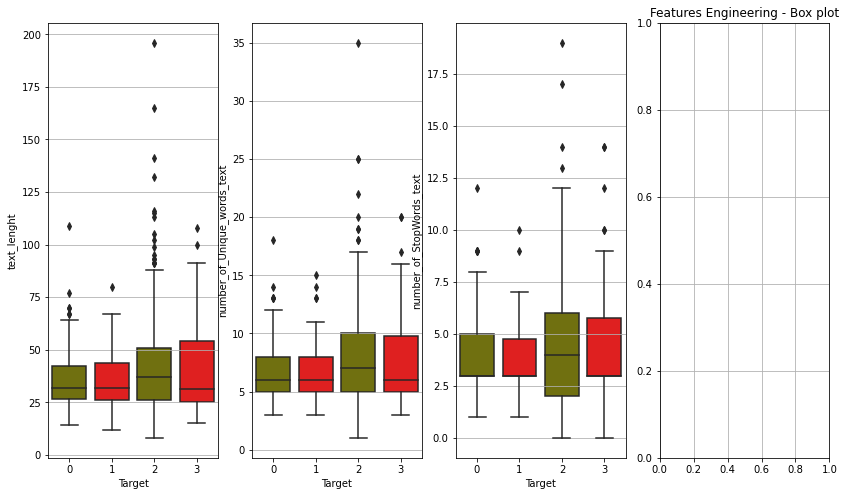

In [48]:
#Calculate number of obs per group & median to position labels
list_var = ['text_lenght', 'number_of_Unique_words_text', 'number_of_StopWords_text']
def violin_boxplott(df,X='Target',Y=list_var, Title='Features Engineering - Box plot'): 
    fig, (ax1, ax2 ,ax3,ax4) = plt.subplots(1,4 ,figsize=(14,8))#, sharey=True )
    medians = Train.groupby(['Target'])['text_lenght', 'number_of_Unique_words_text', 'number_of_StopWords_text'].median().values
 
    sns.boxplot( y=list_var[0],  x=X , data = df, ax= ax1 , palette=['olive','red'])
    sns.boxplot( y=list_var[1],  x=X , data = df, ax= ax2 , palette=['olive','red'])
    sns.boxplot( y=list_var[2],  x=X , data = df, ax= ax3 , palette=['olive','red'])
    #sns.boxplot( y=list_var[3],  x=X , data = df, ax= ax4 , palette=['olive','red'])
    plt.title(Title)
    plt.show()
    #plt.savefig("Features_Engineering_Boxplot")
violin_boxplott(df=Train)

## Testing data

In [49]:
Test.head()

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?


In [50]:
missing_data(Test)

,ID,text
Total,0,0
Percent,0,0
Types,object,object


In [51]:
# Test tweet
print("Alcohol Tweet example :",Test['text'].values[0])



Alcohol Tweet example : How to overcome bad feelings and emotions


In [52]:
#Cleaning the train data 
Test['text_clean_test'] = Test['text'].apply(clean_str)

#Tokenizing and stopwords removing
Test['tokeniZ_stopWords_text_test'] = Test['text_clean_test'].apply(tokeniZ_stopWords)
#Words Stemming
Test['stemming_text_test'] = [[ps.stem(word) for word in words] for words in Test['tokeniZ_stopWords_text_test'] ]
Test['stemming_text_for_tfidf_test'] = [' '.join(words) for words in Test['stemming_text_test']] 

#Words lemmatization
Test['lemmatize_text_test'] = Test['tokeniZ_stopWords_text_test'].apply(lemat_words)
Test['lemmatize_text_for_tfidf_test'] = [' '.join(x) for x in Test['lemmatize_text_test'] ]

#Calcul longueur des commentaires
Test['text_lenght_test'] = Test['text'].apply(len)

#Calcul du nombre de ponctuation par question
from string import punctuation
Test['number_punctuation_text_test'] = Test['text'].apply(
    lambda doc: len([word for word in str(doc) if word in punctuation])) 

#Number of unique words in the text
Test['number_of_Unique_words_text_test'] = Test['text_clean_test'].apply([lambda x : len(set(str(x).split()))])
#test
#Number of stopwords in the text
list_stopWords = set(stopwords.words('english'))
Test['number_of_StopWords_text_test'] = Test['text_clean_test'].apply(
    lambda x : len([w for w in x.lower().split() if w in list_stopWords ]))


#Number of upper case words
Test['number_of_uppercase_text_test'] = Test['text'].apply(
    lambda x : len([w for w in x.split() if w.isupper()]))


#Average length of words in the text (whithout stop words)
Test['average_of_wordsLength_text_test'] = Test['text_clean_test'].apply(
    lambda x : np.mean([len(w) for w in x.split()]))

#Number of words in the text
Test['number_of_words_text_test'] = Test['text_clean_test'].apply([lambda x : len(str(x).split())])

In [53]:
Test.head()

,ID,text,text_clean_test,tokeniZ_stopWords_text_test,stemming_text_test,stemming_text_for_tfidf_test,lemmatize_text_test,lemmatize_text_for_tfidf_test,text_lenght_test,number_punctuation_text_test,number_of_Unique_words_text_test,number_of_StopWords_text_test,number_of_uppercase_text_test,average_of_wordsLength_text_test,number_of_words_text_test
0,02V56KMO,How to overcome bad feelings and emotions,how to overcome bad feelings and emotions,"[overcome, bad, feelings, emotions]","[overcom, bad, feel, emot]",overcom bad feel emot,"[overcome, bad, feeling, emotion]",overcome bad feeling emotion,41,0,7,3,0,5.000000,7
1,03BMGTOK,I feel like giving up in life,i feel like giving up in life,"[feel, like, giving, life]","[feel, like, give, life]",feel like give life,"[feel, like, give, life]",feel like give life,30,0,7,3,1,3.285714,7
2,03LZVFM6,I was so depressed feel like got no strength t...,i was so depressed feel like got no strength t...,"[depressed, feel, like, got, strength, continue]","[depress, feel, like, got, strength, continu]",depress feel like got strength continu,"[depressed, feel, like, get, strength, continue]",depressed feel like get strength continue,56,0,11,5,1,4.181818,11
3,0EPULUM5,I feel so low especially since I had no one to...,i feel so low especially since i had no one to...,"[feel, low, especially, since, one, talk]","[feel, low, especi, sinc, one, talk]",feel low especi sinc one talk,"[feel, low, especially, since, one, talk]",feel low especially since one talk,54,0,11,7,2,3.230769,13
4,0GM4C5GD,can i be successful when I am a drug addict?,can i be successful when i am a drug addict,"[successful, drug, addict]","[success, drug, addict]",success drug addict,"[successful, drug, addict]",successful drug addict,45,1,9,7,1,3.400000,10


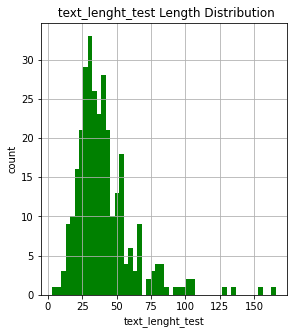

In [54]:
# Sentence length analysis

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(Test['text_lenght_test'],bins=50,color='g')
plt.title(' text_lenght_test Length Distribution')
plt.xlabel('text_lenght_test')
plt.ylabel('count')




plt.show()




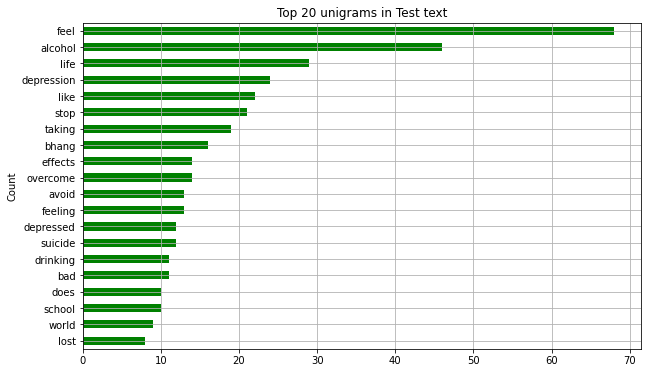

In [55]:
#Distribution of top unigrams
Test_unigrams = get_top_n_words(Test['text_clean_test'],20)

df1 = pd.DataFrame(Test_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='g')
plt.ylabel('Count')
plt.title('Top 20 unigrams in Test text')
plt.show()



In [56]:
 ## Preprocess Selected_text
Test_test = Test['text']
Text_clean_test = Test_test.apply(clean_str)

In [57]:
top_words_in_text_test = get_top_n_words(Text_clean_test)
p_test1 = [x[0] for x in top_words_in_text_test[:20]]
p_test2 = [x[1] for x in top_words_in_text_test[:20]]



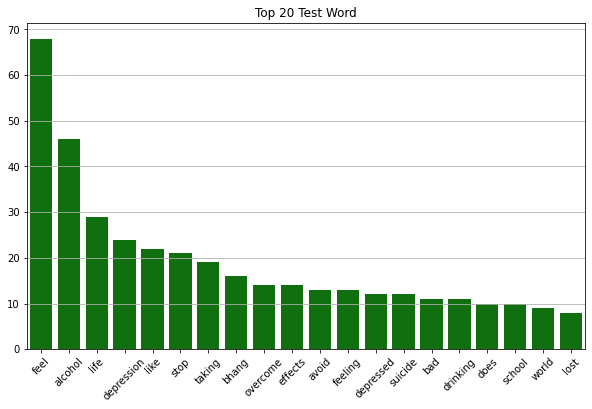

In [58]:
# Top positive word
sns.barplot(x=p_test1,y=p_test2,color = 'green')
plt.xticks(rotation=45)
plt.title('Top 20 Test Word')
plt.show()

In [59]:
Test_bigrams = get_top_n_gram(Test['text_clean_test'],(2,2))
df_Test_bigrams = pd.DataFrame(Test_bigrams, columns = ['Text' , 'count'])
df_Test_bigrams.shape

(653, 2)

In [60]:
df_Test_bigrams.head()

,Text,count
0,feel like,17
1,taking alcohol,8
2,school fees,7
3,commit suicide,6
4,stop taking,6


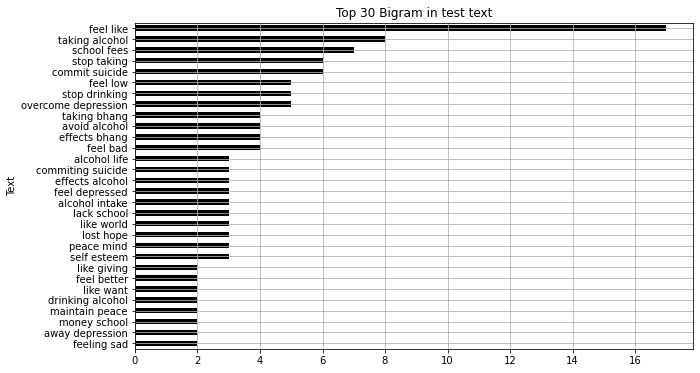

In [61]:
Text_bigrams = get_top_n_gram(Test['text_clean_test'],(2,2),30)
df_Text_bigrams = pd.DataFrame(Text_bigrams, columns = ['Text' , 'count'])
df_Text_bigrams.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='black')
plt.title('Top 30 Bigram in test text')
plt.show()

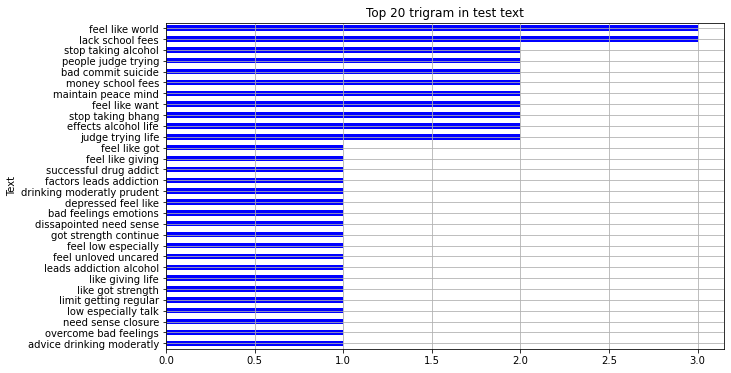

In [62]:
Test_trigrams = get_top_n_gram(Test['text_clean_test'],(3,3),30)
df_Test_trigrams = pd.DataFrame(Test_trigrams, columns = ['Text' , 'count'])
df_Test_trigrams.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='blue')
plt.title('Top 20 trigram in test text')
plt.show()

In [63]:
#Test_trigrams


In [64]:
test_bigrams = get_top_n_gram(Test['text_clean_test'],(2,2))
df_test_bigrams = pd.DataFrame(test_bigrams, columns = ['Text' , 'count'])

In [65]:
Test.shape

(309, 15)

In [66]:
df_test_bigrams.shape

(653, 2)

In [67]:
test_bigrams

[('feel like', 17),
 ('taking alcohol', 8),
 ('school fees', 7),
 ('commit suicide', 6),
 ('stop taking', 6),
 ('feel low', 5),
 ('overcome depression', 5),
 ('stop drinking', 5),
 ('avoid alcohol', 4),
 ('effects bhang', 4),
 ('taking bhang', 4),
 ('feel bad', 4),
 ('lost hope', 3),
 ('alcohol intake', 3),
 ('commiting suicide', 3),
 ('self esteem', 3),
 ('like world', 3),
 ('peace mind', 3),
 ('lack school', 3),
 ('alcohol life', 3),
 ('effects alcohol', 3),
 ('feel depressed', 3),
 ('like giving', 2),
 ('feeling sad', 2),
 ('feel better', 2),
 ('money school', 2),
 ('like want', 2),
 ('away depression', 2),
 ('maintain peace', 2),
 ('drinking alcohol', 2),
 ('does god', 2),
 ('using alcohol', 2),
 ('feel overwhelmed', 2),
 ('bad commit', 2),
 ('feel sad', 2),
 ('alcohol health', 2),
 ('suicidal thoughts', 2),
 ('taking drugs', 2),
 ('cope stress', 2),
 ('feel life', 2),
 ('life unfair', 2),
 ('people judge', 2),
 ('judge trying', 2),
 ('trying life', 2),
 ('feel lonely', 2),
 ('life

In [68]:
Depression_bigrams

[('feel like', 32),
 ('feel low', 12),
 ('like giving', 7),
 ('feel better', 6),
 ('like world', 6),
 ('feel sad', 6),
 ('causes depression', 6),
 ('feel bad', 5),
 ('feel depressed', 5),
 ('feel lonely', 5),
 ('sad lonely', 4),
 ('relationship issues', 4),
 ('self esteem', 4),
 ('overcome depression', 4),
 ('like life', 4),
 ('low self', 3),
 ('giving life', 3),
 ('lack financial', 2),
 ('financial support', 2),
 ('effects depression', 2),
 ('feel hopeless', 2),
 ('falling apart', 2),
 ('feel rejected', 2),
 ('depressed person', 2),
 ('depression effects', 2),
 ('feel confused', 2),
 ('feel unworthy', 2),
 ('reason depression', 2),
 ('overcome feeling', 2),
 ('feelings anxiety', 2)]

In [69]:
Depression_bigrams = get_top_n_gram(Depression['text_clean'],(2,2))
Drugs_bigrams = get_top_n_gram(Drugs['text_clean'],(2,2))
Suicide_bigrams = get_top_n_gram(Suicide['text_clean'],(2,2))
Alcohol_bigrams = get_top_n_gram(Alcohol['text_clean'],(2,2))

# Finding top trigram
Depression_trigrams = get_top_n_gram(Depression['text_clean'],(3,3))
Drugs_trigrams = get_top_n_gram(Drugs['text_clean'],(3,3))
Suicide_trigrams = get_top_n_gram(Suicide['text_clean'],(3,3))
Alcohol_trigrams = get_top_n_gram(Alcohol['text_clean'],(3,3))




In [70]:
type(Depression_bigrams)

list

In [71]:
def token_level_to_char_level(text, offsets, preds):
    probas_char = np.zeros(len(text))
    for i, offset in enumerate(offsets):
        if offset[0] or offset[1]: # remove padding and sentiment
            probas_char[offset[0]:offset[1]] = preds[i]
    
    return probas_char

##  TensorFlow roBERTa

In [72]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
print('TF version',tf.__version__)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


TF version 2.2.0


In [73]:
def read_train():
    train=pd.read_csv('/kaggle/input/trainzindi/Train.csv')
    train['text']=train['text'].astype(str)
    return train

def read_test():
    test=pd.read_csv('/kaggle/input/testzindi/Test.csv')
    test['text']=test['text'].astype(str)
    return test

def read_submission():
    test=pd.read_csv('/kaggle/input/tech4mentalhealthsamplesubmission/SampleSubmission.csv')
    return test
    
train_df = read_train()
test_df = read_test()
submission_df = read_submission()

In [74]:
train_df

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression
...,...,...,...
611,BOHSNXCN,What should I do to stop alcoholism?,Alcohol
612,GVDXRQPY,How to become my oldself again,Suicide
613,IO4JHIQS,How can someone stop it?,Alcohol
614,1DS3P1XO,I feel unworthy,Depression


In [75]:
def jaccard(str1, str2): 
    a = set(str(str1).lower().split()) 
    b = set(str(str2).lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [76]:
MAX_LEN = 96
PATH = '/kaggle/input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
label_id = {'Depression': 352, 'Alcohol': 140, 'Suicide': 66, 'Drugs':58}

In [77]:
PATH

'/kaggle/input/tf-roberta/'

In [78]:
ct = train_df.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train_df.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train_df.loc[k,'text'].split())
    idx = text1.find(text1)
    chars = np.zeros((len(text1)))
    #chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = label_id[train_df.loc[k,'label']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

In [79]:
ct = test_df.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test_df.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test_df.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    #s_tok = label_id[test_df.loc[k,'label']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

## Model 

In [80]:
def scheduler(epoch):
    return 3e-5 * 0.2**epoch

In [81]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(128, 2,padding='same')(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Conv1D(64, 2,padding='same')(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(128, 2, padding='same')(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Conv1D(64, 2, padding='same')(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    return model

In [82]:
n_splits = 5

In [83]:

jac = []; VER='v4'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=777)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train_df.label.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')
        
    hist = model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        epochs=5, batch_size=8, verbose=DISPLAY, callbacks=[sv, reduce_lr],
        validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        [start_tokens[idxV,], end_tokens[idxV,]]))
    
    print('Loading model...')
    model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train_df.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train_df.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st,train_df.loc[k,'text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()


#########################
### FOLD 1
#########################
Epoch 1/5
62/62 [==============================] - ETA: 0s - loss: 0.0209 - activation_loss: 0.0105 - activation_1_loss: 0.0105
Epoch 00001: val_loss improved from inf to 0.02094, saving model to v4-roberta-0.h5
62/62 [==============================] - 14s 222ms/step - loss: 0.0209 - activation_loss: 0.0105 - activation_1_loss: 0.0105 - val_loss: 0.0209 - val_activation_loss: 0.0105 - val_activation_1_loss: 0.0105 - lr: 3.0000e-05
Epoch 2/5
62/62 [==============================] - ETA: 0s - loss: 0.0209 - activation_loss: 0.0105 - activation_1_loss: 0.0105
Epoch 00002: val_loss improved from 0.02094 to 0.02094, saving model to v4-roberta-0.h5
62/62 [==============================] - 10s 165ms/step - loss: 0.0209 - activation_loss: 0.0105 - activation_1_loss: 0.0105 - val_loss: 0.0209 - val_activation_loss: 0.0105 - val_activation_1_loss: 0.0105 - lr: 6.0000e-06
Epoch 3/5
62/62 [==============================] - ETA: 0s - lo

In [84]:
print('>>>> OVERALL 5 Fold CV Jaccard =',np.mean(jac))
print(jac) # Jaccard CVs

>>>> OVERALL 5 Fold CV Jaccard = 0.5032585474879091
[0.679935921796503, 0.5043879110952282, 0.33054514365489973, 0.6155855210733259, 0.3858382398195885]


In [85]:
type(all)

list

In [86]:
np.shape(all) 

(123,)

In [87]:
test_df = test_df.dropna()

In [88]:
test_df.shape

(309, 2)

In [89]:
pd.set_option('display.max_rows', None)
#test_df.apply(lambda col: col.drop_duplicates().reset_index(drop=True))

In [90]:
test_df.size

618

In [91]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [92]:
test_df.head()

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?


In [93]:

all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(oof_start[k,])
    b = np.argmax(oof_end[k,])
    if a>b: 
        st = test_df.loc[k,'text']
    else:
        text1 = " "+" ".join(test_df.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-2:b-1])
    all.append(st)

In [94]:
#test_df.iloc[test_df.index] = False
test_df['text'] = all
test_df[['ID','text']].to_csv('submission.csv',index=False)
test_df.sample(10)

,ID,text
17,22L09P4C,What are the effects of bhang?
244,R5TQVK1E,
277,VVD03CXJ,i feel
27,2SFRZEYJ,can someone overcome heart
2,03LZVFM6,i was
307,ZVIJMA4O,
211,NAFC0V61,the
167,IRVOJF0A,
63,7GV9GMHR,do i mean anything to anybody in this world?
5,0IYM8BYT,of closure


In [95]:
# Visualization training prediction results
all = []
start = []
end = []
start_pred = []
end_pred = []
for k in range(input_ids.shape[0]):
    a = np.argmax(oof_start[k,])
    b = np.argmax(oof_end[k,])
    start.append(np.argmax(start_tokens[k]))
    end.append(np.argmax(end_tokens[k]))        
    if a>b:
        st = train_df.loc[k,'text']
        start_pred.append(0)
        end_pred.append(len(st))
    else:
        text1 = " "+" ".join(train_df.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-2:b-1])
        start_pred.append(a)
        end_pred.append(b)
    all.append(st)
train_df['start'] = start
train_df['end'] = end
train_df['start_pred'] = start_pred
train_df['end_pred'] = end_pred
train_df['text_pred'] = all
train_df.sample(10)

,ID,text,label,start,end,start_pred,end_pred,text_pred
546,NQ7HK3NP,How to handle suicide and incidencesof suicide...,Suicide,0,0,8,95,idencesof suicide to youths
278,1M6N5OI2,How to stop the addiction?,Alcohol,0,0,0,26,How to stop the addiction?
132,P6F3W88R,How can I stop taking bhang?,Drugs,0,0,2,2,how
524,CUERB14Y,Why should I quit bhang?,Drugs,0,0,0,24,Why should I quit bhang?
217,F0I7GIGE,I feel desparate…why is the world so unfair,Depression,0,0,0,43,I feel desparate…why is the world so unfair
552,YKET9W6S,How can i get back selfworth?,Suicide,0,0,2,95,how can i get back selfworth?
268,XBFD6MDZ,I feel so lowI feel good and better now,Depression,0,0,3,95,feel so lowi feel good and better now
41,J9T35NVE,What are the effects of alcohol?,Alcohol,0,0,2,10,what are the effects of alcohol?
190,AP3VVFX6,Will alcohol lead me to a bad place in life,Alcohol,0,0,7,10,a bad place in
416,QNZTZXTG,how can I feel good about myself?,Depression,0,0,10,95,


In [96]:
def metric_tse(df,col1,col2):
    # Calc metric of tse-competition - according to https://www.kaggle.com/c/tweet-sentiment-extraction/overview/evaluation
    return df.apply(lambda x: jaccard(x[col1],x[col2]),axis=1)

In [97]:
train_df

,ID,text,label,start,end,start_pred,end_pred,text_pred
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,0,0,7,10,better i dieam
1,9JDAGUV3,Why do I get hallucinations?,Drugs,0,0,8,8,
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,0,0,2,3,i am
3,6UY7DX6Q,Why is life important?,Suicide,0,0,0,22,Why is life important?
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,0,0,0,51,How could I be helped to go through the depres...
5,V6VSDJ5I,What are the effects of depression to ones health,Depression,0,0,0,95,ones health
6,9736J4UE,Why is everything so hard to deal with in this...,Depression,0,0,0,95,this life
7,AY8L479Y,I feel emotionally overwhelmed,Depression,0,0,5,95,overwhelmed
8,OSFJV5EC,How to manage taking alcohol?,Alcohol,0,0,0,29,How to manage taking alcohol?
9,U4SGUGGM,Is heaven open for us who smoke bhang?,Drugs,0,0,0,38,Is heaven open for us who smoke bhang?


In [98]:
# Analytics
train_df = train_df.replace({'label': {'Depression': -1, 'Alcohol': 0, 'Suicide': 1, 'Drugs':2}})
train_df['len_text'] = train_df['text'].str.len()

train_df['diff_num'] = train_df['end']-train_df['start']


In [99]:
# Prediction analytics
train_df['text_pred'] = train_df['text_pred'].map(lambda x: x.lstrip(' '))
train_df['len_text_pred'] = train_df['text_pred'].str.len()
train_df['diff_num_pred'] = train_df['end_pred']-train_df['start_pred']
train_df['share_pred'] = train_df['len_text_pred']/train_df['len_text']
# len_equal
train_df['len_equal'] = 0
train_df.loc[(train_df['start'] == train_df['start_pred']) & (train_df['end'] == train_df['end_pred']), 'len_equal'] = 1
# metric
train_df['metric'] = metric_tse(train_df,'text','text_pred')
# res
train_df['res'] = 0
train_df.loc[train_df['metric'] == 1, 'res'] = 1

In [100]:
def rep_3chr(text):
    # Checks if there are 3 or more repetitions of characters in words
    chr3 = 0
    for word in text.split():
        for c in set(word):
            if word.rfind(c+c+c) > -1:
                chr3 = 1                
    return chr3

In [101]:
# Analysis of 3 or more repetitions of characters in words
train_df['text_chr3'] = train_df['text'].apply(rep_3chr)

train_df['text_pred_chr3'] = train_df['text_pred'].apply(rep_3chr)

In [102]:
# result
col_interesting = ['label', 'len_text', 'text_chr3', 'diff_num', 'text', 'text_pred', 'len_text_pred', 'diff_num_pred', 'share_pred',
                   'text_pred_chr3', 'len_equal', 'metric', 'res']
train_df[col_interesting].head(10)

,label,len_text,text_chr3,diff_num,text,text_pred,len_text_pred,diff_num_pred,share_pred,text_pred_chr3,len_equal,metric,res
0,-1,39,0,0,I feel that it was better I dieAm happy,better i dieam,14,3,0.358974,0,0,0.375000,0
1,2,28,0,0,Why do I get hallucinations?,,0,0,0.000000,0,0,0.000000,0
2,-1,57,0,0,I am stresseed due to lack of financial suppor...,i am,4,1,0.070175,0,0,0.181818,0
3,1,22,0,0,Why is life important?,Why is life important?,22,22,1.000000,0,0,1.000000,1
4,-1,51,0,0,How could I be helped to go through the depres...,How could I be helped to go through the depres...,51,51,1.000000,0,0,1.000000,1
5,-1,49,0,0,What are the effects of depression to ones health,ones health,11,95,0.224490,0,0,0.222222,0
6,-1,51,0,0,Why is everything so hard to deal with in this...,this life,9,95,0.176471,0,0,0.181818,0
7,-1,32,0,0,I feel emotionally overwhelmed,overwhelmed,11,90,0.343750,0,0,0.250000,0
8,0,29,0,0,How to manage taking alcohol?,How to manage taking alcohol?,29,29,1.000000,0,0,1.000000,1
9,2,38,0,0,Is heaven open for us who smoke bhang?,Is heaven open for us who smoke bhang?,38,38,1.000000,0,0,1.000000,1


In [103]:
print('Total metric =',train_df['metric'].mean())

Total metric = 0.4736582004345664


In [104]:
train_df.describe()

,label,start,end,start_pred,end_pred,len_text,diff_num,len_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,text_pred_chr3
count,616.000000,616.0,616.0,616.000000,616.000000,616.000000,616.0,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.0
mean,-0.275974,0.0,0.0,6.237013,49.780844,39.813312,0.0,19.448052,43.543831,0.481678,0.003247,0.473658,0.300325,0.001623,0.0
std,0.990265,0.0,0.0,16.712169,39.800711,21.438797,0.0,21.746071,38.452691,0.416860,0.056934,0.416507,0.458772,0.040291,0.0
min,-1.000000,0.0,0.0,0.000000,0.000000,8.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,-1.000000,0.0,0.0,0.000000,8.000000,26.000000,0.0,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,-1.000000,0.0,0.0,2.000000,39.500000,35.000000,0.0,13.000000,34.000000,0.422065,0.000000,0.400000,0.000000,0.000000,0.0
75%,0.000000,0.0,0.0,6.000000,95.000000,48.250000,0.0,31.000000,87.250000,1.000000,0.000000,1.000000,1.000000,0.000000,0.0
max,2.000000,0.0,0.0,95.000000,141.000000,196.000000,0.0,178.000000,141.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [105]:
# Outlier
train_df_outlier = train_df[train_df['res'] == 0].reset_index(drop=True)
train_df_outlier

,ID,text,label,start,end,start_pred,end_pred,text_pred,len_text,diff_num,len_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,text_pred_chr3
0,SUAVK39Z,I feel that it was better I dieAm happy,-1,0,0,7,10,better i dieam,39,0,14,3,0.358974,0,0.375000,0,0,0
1,9JDAGUV3,Why do I get hallucinations?,2,0,0,8,8,,28,0,0,0,0.000000,0,0.000000,0,0,0
2,419WR1LQ,I am stresseed due to lack of financial suppor...,-1,0,0,2,3,i am,57,0,4,1,0.070175,0,0.181818,0,0,0
3,V6VSDJ5I,What are the effects of depression to ones health,-1,0,0,0,95,ones health,49,0,11,95,0.224490,0,0.222222,0,0,0
4,9736J4UE,Why is everything so hard to deal with in this...,-1,0,0,0,95,this life,51,0,9,95,0.176471,0,0.181818,0,0,0
5,AY8L479Y,I feel emotionally overwhelmed,-1,0,0,5,95,overwhelmed,32,0,11,90,0.343750,0,0.250000,0,0,0
6,LM8GPR0X,How do i stop this? What do I do when life bec...,0,0,0,17,95,,62,0,0,78,0.000000,0,0.000000,0,0,0
7,EIF8Y8MX,"I was ever sad,alone and always on drugsNow I ...",-1,0,0,15,95,how to cope with negative aspects in my life,95,0,44,80,0.463158,0,0.500000,0,0,0
8,03TVUJ9J,"I feel empty,absent minded",-1,0,0,4,95,"empty,absent minded",26,0,19,91,0.730769,0,0.500000,0,0,0
9,CBMIYRK7,I experienced depression in my studies,-1,0,0,1,2,,38,0,0,1,0.000000,0,0.000000,0,0,0


In [106]:
train_df_outlier.describe()

,label,start,end,start_pred,end_pred,len_text,diff_num,len_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,text_pred_chr3
count,431.000000,431.0,431.0,431.000000,431.000000,431.000000,431.0,431.000000,431.000000,431.000000,431.000000,431.000000,431.0,431.000000,431.0
mean,-0.320186,0.0,0.0,8.828306,51.867749,39.779582,0.0,10.705336,43.039443,0.260099,0.004640,0.247734,0.0,0.002320,0.0
std,0.976246,0.0,0.0,19.413571,44.476894,21.953548,0.0,15.687321,42.986811,0.290928,0.068041,0.278861,0.0,0.048168,0.0
min,-1.000000,0.0,0.0,0.000000,0.000000,8.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
25%,-1.000000,0.0,0.0,1.000000,6.000000,26.000000,0.0,0.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
50%,-1.000000,0.0,0.0,4.000000,94.000000,35.000000,0.0,5.000000,8.000000,0.142857,0.000000,0.166667,0.0,0.000000,0.0
75%,0.000000,0.0,0.0,7.000000,95.000000,46.000000,0.0,16.000000,89.000000,0.463722,0.000000,0.477273,0.0,0.000000,0.0
max,2.000000,0.0,0.0,95.000000,95.000000,196.000000,0.0,178.000000,95.000000,0.948718,1.000000,0.914286,0.0,1.000000,0.0


In [107]:
sh_out = str(round(len(train_df_outlier)*100/len(train_df),1))
print('Number of outliers is ' + sh_out + '% from training data')

Number of outliers is 70.0% from training data


In [108]:
# Good prediction
train_good = train_df[train_df['res'] == 1].reset_index(drop=True)
train_good

,ID,text,label,start,end,start_pred,end_pred,text_pred,len_text,diff_num,len_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,text_pred_chr3
0,6UY7DX6Q,Why is life important?,1,0,0,0,22,Why is life important?,22,0,22,22,1.000000,0,1.0,1,0,0
1,FYC0FTFB,How could I be helped to go through the depres...,-1,0,0,0,51,How could I be helped to go through the depres...,51,0,51,51,1.000000,0,1.0,1,0,0
2,OSFJV5EC,How to manage taking alcohol?,0,0,0,0,29,How to manage taking alcohol?,29,0,29,29,1.000000,0,1.0,1,0,0
3,U4SGUGGM,Is heaven open for us who smoke bhang?,2,0,0,0,38,Is heaven open for us who smoke bhang?,38,0,38,38,1.000000,0,1.0,1,0,0
4,JGBMEUC1,How to survive without money?,-1,0,0,0,29,How to survive without money?,29,0,29,29,1.000000,0,1.0,1,0,0
5,0LPO6TKU,What should i do to get out of depression?,-1,0,0,0,42,What should i do to get out of depression?,42,0,42,42,1.000000,0,1.0,1,0,0
6,4DDQ2BRX,I just stopped taking alcohol because i though...,0,0,0,2,95,i just stopped taking alcohol because i though...,70,0,70,93,1.000000,0,1.0,1,0,0
7,93G4A70N,How does one avoid bad company?,2,0,0,0,32,How does one avoid bad company?,32,0,32,32,1.000000,0,1.0,1,0,0
8,X45W9Q0S,How to avoiod depression in campus,-1,0,0,0,34,How to avoiod depression in campus,34,0,34,34,1.000000,0,1.0,1,0,0
9,ZBUCI1MA,Causes of suicide by youths,1,0,0,0,27,Causes of suicide by youths,27,0,27,27,1.000000,0,1.0,1,0,0


In [109]:
train_good.describe()

,label,start,end,start_pred,end_pred,len_text,diff_num,len_text_pred,diff_num_pred,share_pred,len_equal,metric,res,text_chr3,text_pred_chr3
count,185.000000,185.0,185.0,185.000000,185.000000,185.000000,185.0,185.000000,185.000000,185.000000,185.0,185.0,185.0,185.0,185.0
mean,-0.172973,0.0,0.0,0.200000,44.918919,39.891892,0.0,39.816216,44.718919,0.997898,0.0,1.0,1.0,0.0,0.0
std,1.017416,0.0,0.0,0.615029,25.253689,20.246288,0.0,20.231775,24.934412,0.009015,0.0,0.0,0.0,0.0,0.0
min,-1.000000,0.0,0.0,0.000000,9.000000,10.000000,0.0,10.000000,7.000000,0.923077,0.0,1.0,1.0,0.0,0.0
25%,-1.000000,0.0,0.0,0.000000,29.000000,28.000000,0.0,28.000000,29.000000,1.000000,0.0,1.0,1.0,0.0,0.0
50%,-1.000000,0.0,0.0,0.000000,38.000000,35.000000,0.0,35.000000,38.000000,1.000000,0.0,1.0,1.0,0.0,0.0
75%,0.000000,0.0,0.0,0.000000,56.000000,51.000000,0.0,51.000000,56.000000,1.000000,0.0,1.0,1.0,0.0,0.0
max,2.000000,0.0,0.0,3.000000,141.000000,141.000000,0.0,141.000000,141.000000,1.000000,0.0,1.0,1.0,0.0,0.0


Share of all data


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd74525f610>,
      dtype=object)

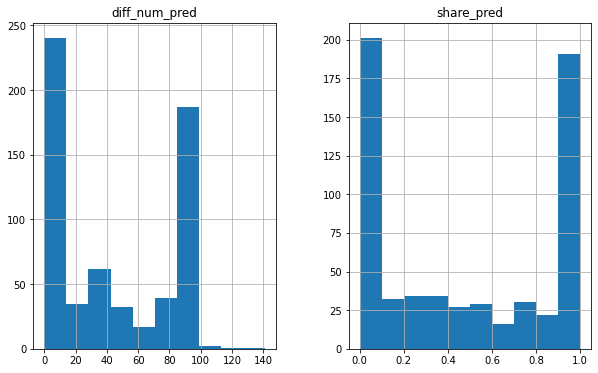

In [110]:
print('Share of all data')
train_df[['diff_num_pred', 'share_pred']].hist(bins=10)

In [111]:
pwd

'/kaggle/working'

In [112]:
#ls

In [113]:
#/kaggle/input/tf-roberta/pretrained-roberta-base.h5
#/kaggle/input/v4roberta/v4-roberta-3.h5

import numpy as np
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))
DISPLAY=1
for i in range(5):
    print('#'*25)
    print('### MODEL %i'%(i+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
    model.load_weights('/kaggle/input/v4roberta/v4-roberta-%i.h5'%i)

    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/n_splits
    preds_end += preds[1]/n_splits

#########################
### MODEL 1
#########################
Predicting Test...
10/10 [==============================] - 1s 123ms/step
#########################
### MODEL 2
#########################
Predicting Test...
10/10 [==============================] - 1s 121ms/step
#########################
### MODEL 3
#########################
Predicting Test...
10/10 [==============================] - 1s 132ms/step
#########################
### MODEL 4
#########################
Predicting Test...
10/10 [==============================] - 1s 128ms/step
#########################
### MODEL 5
#########################
Predicting Test...
10/10 [==============================] - 1s 122ms/step


In [114]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(oof_start[k,])
    b = np.argmax(oof_end[k,])
    if a>b: 
        st = test_df.loc[k,'text']
    else:
        text1 = " "+" ".join(test_df.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)

In [115]:
#all

In [116]:
test = Test[["ID", "text"]]


In [117]:
test_df['text'] = all
test_df[['ID','text']].to_csv('submission1.csv',index=False)

In [118]:
test_df

,ID,text
0,02V56KMO,
1,03BMGTOK,
2,03LZVFM6,was
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?
5,0IYM8BYT,closure
6,0JFJVD28,hope
7,0OZGUFOF,ared for
8,0WP999ZX,What are factors that leads to addiction of al...
9,0ZA45Y5F,"Is the advice of drinking moderatly ,prudent?"


In [119]:
test['text'] = np.where(test['text'] == test_df['text'], 'True', 'False')

In [120]:
Test['ID'] = np.where(Test['ID'] == submission_df['ID'], 'True', 'False')

In [121]:
#Test

In [122]:
#test
test_df

,ID,text
0,02V56KMO,
1,03BMGTOK,
2,03LZVFM6,was
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?
5,0IYM8BYT,closure
6,0JFJVD28,hope
7,0OZGUFOF,ared for
8,0WP999ZX,What are factors that leads to addiction of al...
9,0ZA45Y5F,"Is the advice of drinking moderatly ,prudent?"


In [123]:
#Cleaning the train data 
test_df['text_clean_test_df'] = test_df['text'].apply(clean_str)

#Tokenizing and stopwords removing
test_df['tokeniZ_stopWords_text_test_df'] = test_df['text_clean_test_df'].apply(tokeniZ_stopWords)
#Words Stemming
test_df['stemming_text_test_df'] = [[ps.stem(word) for word in words] for words in test_df['tokeniZ_stopWords_text_test_df'] ]
test_df['stemming_text_for_tfidf_test_df'] = [' '.join(words) for words in test_df['stemming_text_test_df']] 

#Words lemmatization
test_df['lemmatize_text_test_df'] = test_df['tokeniZ_stopWords_text_test_df'].apply(lemat_words)
test_df['lemmatize_text_for_tfidf_test_df'] = [' '.join(x) for x in test_df['lemmatize_text_test_df'] ]

#Calcul longueur des commentaires
test_df['text_lenght_test_df'] = test_df['text'].apply(len)

#Calcul du nombre de ponctuation par question
from string import punctuation
test_df['number_punctuation_text_test_df'] = test_df['text'].apply(
    lambda doc: len([word for word in str(doc) if word in punctuation])) 

#Number of unique words in the text
test_df['number_of_Unique_words_text_test_df'] = test_df['text_clean_test_df'].apply([lambda x : len(set(str(x).split()))])
#test
#Number of stopwords in the text
list_stopWords = set(stopwords.words('english'))
test_df['number_of_StopWords_text_test_df'] = test_df['text_clean_test_df'].apply(
    lambda x : len([w for w in x.lower().split() if w in list_stopWords ]))


#Number of upper case words
test_df['number_of_uppercase_text_test_df'] = test_df['text'].apply(
    lambda x : len([w for w in x.split() if w.isupper()]))


#Average length of words in the text (whithout stop words)
test_df['average_of_wordsLength_text_test_df'] = test_df['text_clean_test_df'].apply(
    lambda x : np.mean([len(w) for w in x.split()]))

#Number of words in the text
test_df['number_of_words_text_test_df'] = test_df['text_clean_test_df'].apply([lambda x : len(str(x).split())])

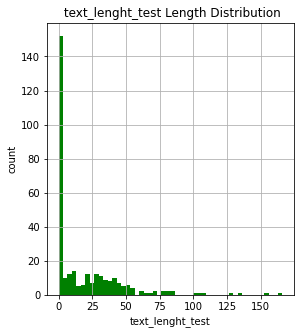

In [124]:
# Sentence length analysis

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(test_df['text_lenght_test_df'],bins=50,color='g')
plt.title(' text_lenght_test Length Distribution')
plt.xlabel('text_lenght_test')
plt.ylabel('count')




plt.show()





In [125]:
test_df

,ID,text,text_clean_test_df,tokeniZ_stopWords_text_test_df,stemming_text_test_df,stemming_text_for_tfidf_test_df,lemmatize_text_test_df,lemmatize_text_for_tfidf_test_df,text_lenght_test_df,number_punctuation_text_test_df,number_of_Unique_words_text_test_df,number_of_StopWords_text_test_df,number_of_uppercase_text_test_df,average_of_wordsLength_text_test_df,number_of_words_text_test_df
0,02V56KMO,,,[],[],,[],,0,0,0,0,0,NaN,0
1,03BMGTOK,,,[],[],,[],,0,0,0,0,0,NaN,0
2,03LZVFM6,was,was,[],[],,[],,4,0,1,1,0,3.000000,1
3,0EPULUM5,I feel so low especially since I had no one to...,i feel so low especially since i had no one to...,"[feel, low, especially, since, one, talk]","[feel, low, especi, sinc, one, talk]",feel low especi sinc one talk,"[feel, low, especially, since, one, talk]",feel low especially since one talk,54,0,11,7,2,3.230769,13
4,0GM4C5GD,can i be successful when I am a drug addict?,can i be successful when i am a drug addict,"[successful, drug, addict]","[success, drug, addict]",success drug addict,"[successful, drug, addict]",successful drug addict,45,1,9,7,1,3.400000,10
5,0IYM8BYT,closure,closure,[closure],[closur],closur,[closure],closure,8,0,1,0,0,7.000000,1
6,0JFJVD28,hope,hope,[hope],[hope],hope,[hope],hope,5,0,1,0,0,4.000000,1
7,0OZGUFOF,ared for,ared for,[ared],[are],are,[ared],ared,8,0,2,1,0,3.500000,2
8,0WP999ZX,What are factors that leads to addiction of al...,what are factors that leads to addiction of al...,"[factors, leads, addiction, alcohol]","[factor, lead, addict, alcohol]",factor lead addict alcohol,"[factor, lead, addiction, alcohol]",factor lead addiction alcohol,51,0,9,5,0,4.777778,9
9,0ZA45Y5F,"Is the advice of drinking moderatly ,prudent?",is the advice of drinking moderatly prudent,"[advice, drinking, moderatly, prudent]","[advic, drink, moderatli, prudent]",advic drink moderatli prudent,"[advice, drink, moderatly, prudent]",advice drink moderatly prudent,45,2,7,3,0,5.285714,7


In [126]:
#test_df_unigrams

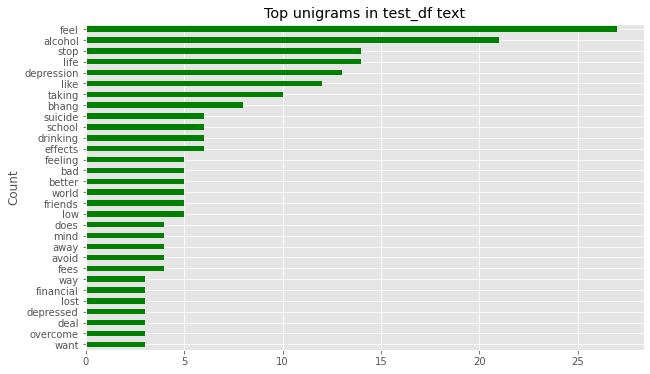

In [127]:
#Distribution of top unigrams
test_df_unigrams = get_top_n_words(test_df['text_clean_test_df'],30)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

test_df_unigrams = pd.DataFrame(test_df_unigrams, columns = ['Text' , 'count'])
test_df_unigrams.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='g')
plt.ylabel('Count')
plt.title('Top unigrams in test_df text')
plt.show()




In [128]:
SampleSubmission

,ID,Depression,Alcohol,Suicide,Drugs
0,02V56KMO,0,0,0,0
1,03BMGTOK,0,0,0,0
2,03LZVFM6,0,0,0,0
3,0EPULUM5,0,0,0,0
4,0GM4C5GD,0,0,0,0
5,0IYM8BYT,0,0,0,0
6,0JFJVD28,0,0,0,0
7,0OZGUFOF,0,0,0,0
8,0WP999ZX,0,0,0,0
9,0ZA45Y5F,0,0,0,0


In [129]:
submission_df["ID"] = test_df["ID"]

In [130]:
submission_df

,ID,Depression,Alcohol,Suicide,Drugs
0,02V56KMO,0,0,0,0
1,03BMGTOK,0,0,0,0
2,03LZVFM6,0,0,0,0
3,0EPULUM5,0,0,0,0
4,0GM4C5GD,0,0,0,0
5,0IYM8BYT,0,0,0,0
6,0JFJVD28,0,0,0,0
7,0OZGUFOF,0,0,0,0
8,0WP999ZX,0,0,0,0
9,0ZA45Y5F,0,0,0,0


In [131]:
test_df.head()

,ID,text,text_clean_test_df,tokeniZ_stopWords_text_test_df,stemming_text_test_df,stemming_text_for_tfidf_test_df,lemmatize_text_test_df,lemmatize_text_for_tfidf_test_df,text_lenght_test_df,number_punctuation_text_test_df,number_of_Unique_words_text_test_df,number_of_StopWords_text_test_df,number_of_uppercase_text_test_df,average_of_wordsLength_text_test_df,number_of_words_text_test_df
0,02V56KMO,,,[],[],,[],,0,0,0,0,0,NaN,0
1,03BMGTOK,,,[],[],,[],,0,0,0,0,0,NaN,0
2,03LZVFM6,was,was,[],[],,[],,4,0,1,1,0,3.000000,1
3,0EPULUM5,I feel so low especially since I had no one to...,i feel so low especially since i had no one to...,"[feel, low, especially, since, one, talk]","[feel, low, especi, sinc, one, talk]",feel low especi sinc one talk,"[feel, low, especially, since, one, talk]",feel low especially since one talk,54,0,11,7,2,3.230769,13
4,0GM4C5GD,can i be successful when I am a drug addict?,can i be successful when i am a drug addict,"[successful, drug, addict]","[success, drug, addict]",success drug addict,"[successful, drug, addict]",successful drug addict,45,1,9,7,1,3.400000,10


In [132]:
test_df_unigrams.shape


(30, 2)

In [133]:
test_df_unigrams

,Text,count
0,feel,27
1,alcohol,21
2,stop,14
3,life,14
4,depression,13
5,like,12
6,taking,10
7,bhang,8
8,drinking,6
9,effects,6


In [134]:
Depression = df1.rename(columns={'Text': 'Depression', 'count': 'count_Depression'})
Drugs = df2.rename(columns={'Text': 'Drugs', 'count': 'count_Drugs'})
Suicide = df3.rename(columns={'Text': 'Suicide', 'count': 'count_Suicide'})
Alcohol = df4.rename(columns={'Text': 'Alcohol', 'count': 'count_Alcohol'})

In [135]:
import h5py

filename = "/kaggle/input/v4roberta/v4-roberta-1.h5"

h5 = h5py.File(filename,'r')
bias_0_data = h5['/conv1d/conv1d/bias:0']
#conv1d = 
#h5.close()

In [136]:
bias_0_data

<HDF5 dataset "bias:0": shape (128,), type "<f4">

In [137]:
type(bias_0_data)

h5py._hl.dataset.Dataset